In [7]:
import sys
sys.path.append('/mnt/antares_raid/home/oliver/nideep')
sys.path.append('/mnt/antares_raid/home/oliver/Scripts/autoencoder')
import os
from TransformMNIST import MNISTtransformer
from CorruptMNIST import MNISTcorrupter
import subprocess
import sys
import caffe
import matplotlib
import numpy as np
import lmdb
import argparse
from collections import defaultdict
import matplotlib.pyplot as plt
import math
from nideep.eval.learning_curve import LearningCurve
from nideep.eval.inference import infer_to_h5_fixed_dims, infer_to_lmdb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nideep.eval.learning_curve import LearningCurve
from nideep.eval.eval_utils import Phase
%matplotlib inline

In [24]:
date = '2408/'
snap = '290000'
caffe_root = '/mnt/antares_raid/home/oliver/adhara/src/caffe/build/tools/caffe'
lmdb_root = '/mnt/raid/dnn/data_oliver/'
root =  "/mnt/antares_raid/home/oliver/Experiments/" + date
init_weights = root + 'Initial_weights/'

test_lmdb = lmdb_root + 'lmdb/MNIST_TEST_10000_rot_lmdb/shuffled/'

deploy_proto = '/mnt/antares_raid/home/oliver/Scripts/deploy_AE_net.prototxt'


models = {
         'UR': '/mnt/antares_raid/home/oliver/Experiments/{}/UR/snapshots/_iter_{}.caffemodel'.format(date,snap),
         'R': '/mnt/antares_raid/home/oliver/Experiments/{}/R/snapshots/_iter_{}.caffemodel'.format(date,snap),
         'N25NR': '/mnt/antares_raid/home/oliver/Experiments/{}/N25NR/snapshots/_iter_{}.caffemodel'.format(date,snap),
         'N25NUR': '/mnt/antares_raid/home/oliver/Experiments/{}/N25NUR/snapshots/_iter_{}.caffemodel'.format(date,snap),
         'N50NR':  '/mnt/antares_raid/home/oliver/Experiments/{}/N50NR/snapshots/_iter_{}.caffemodel'.format(date,snap),
         'N50NUR':  '/mnt/antares_raid/home/oliver/Experiments/{}/N50NUR/snapshots/_iter_{}.caffemodel'.format(date,snap)
        }

N25NR


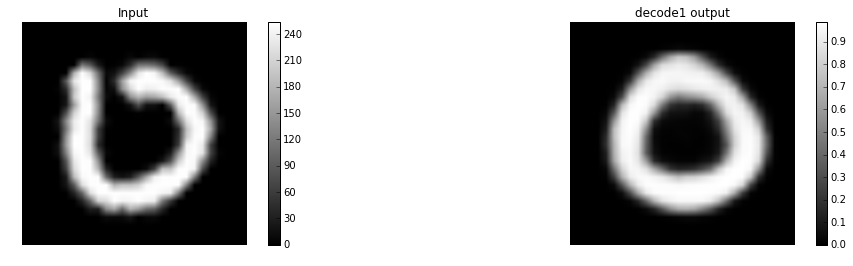

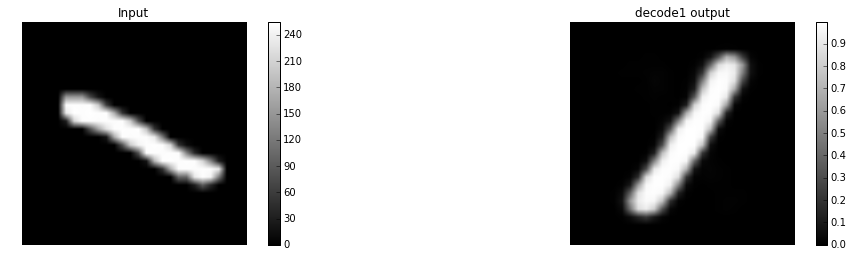

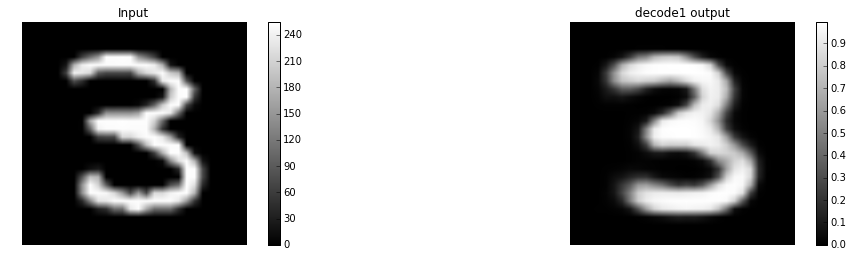

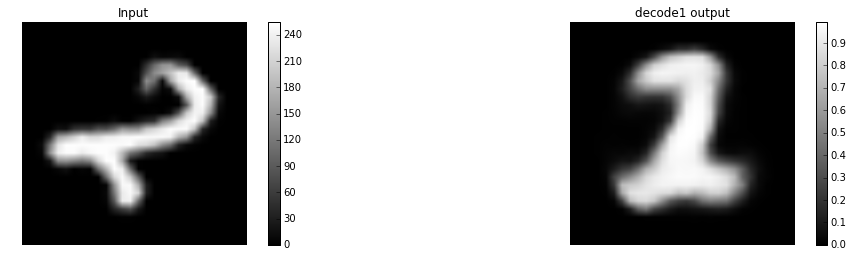

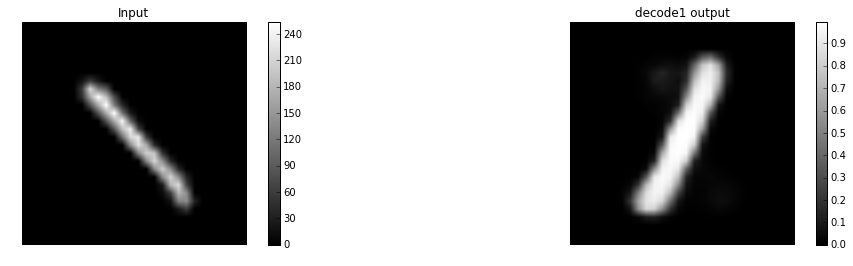

N25NUR


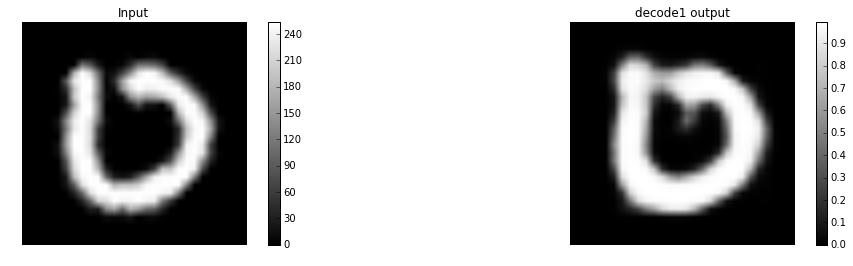

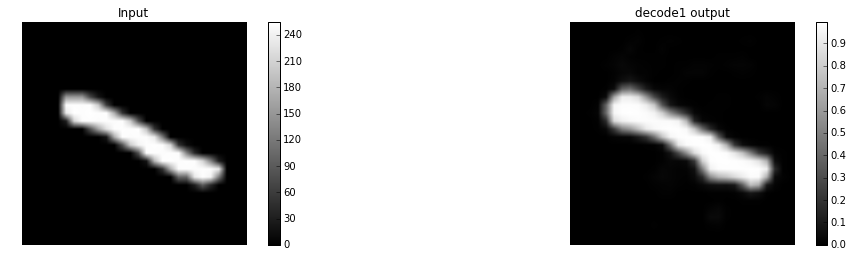

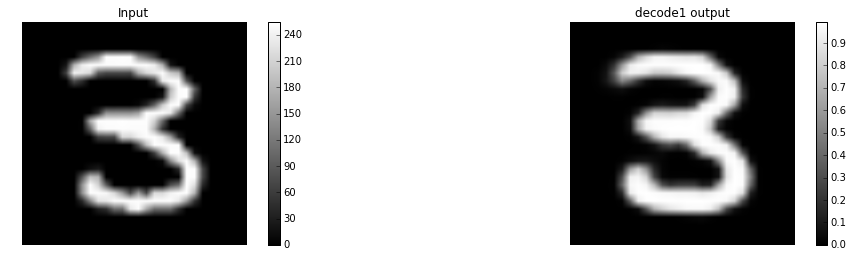

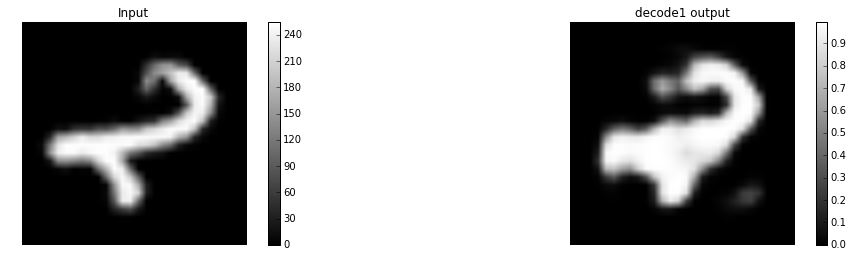

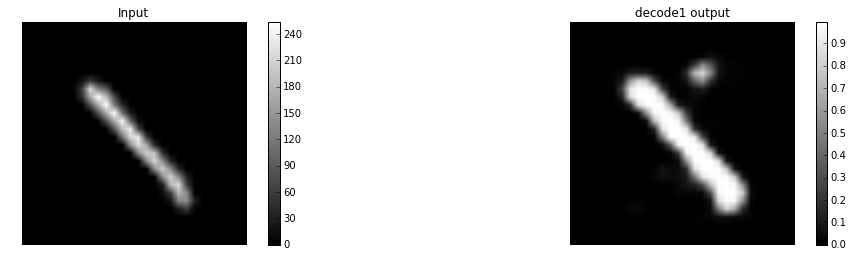

N50NR


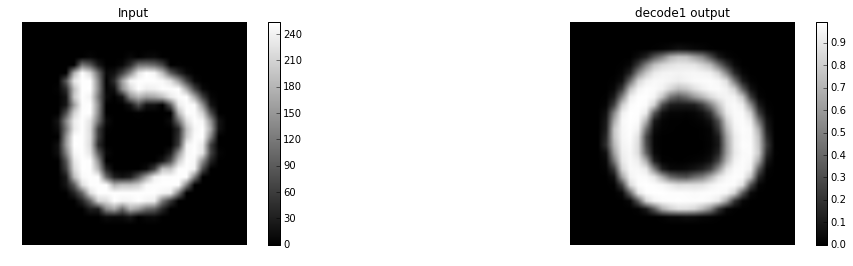

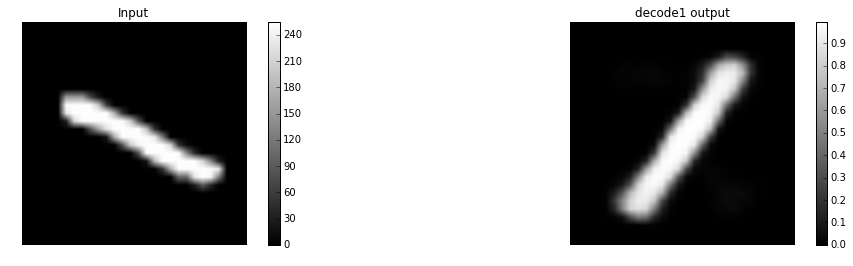

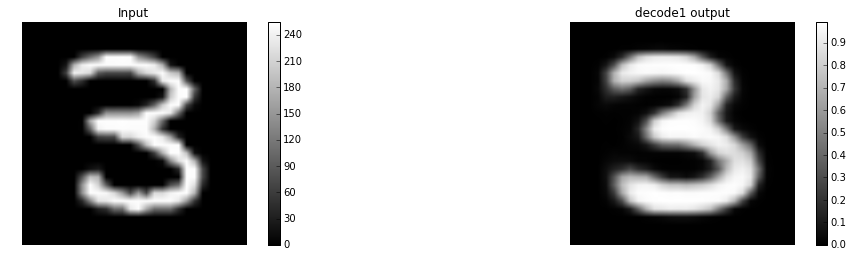

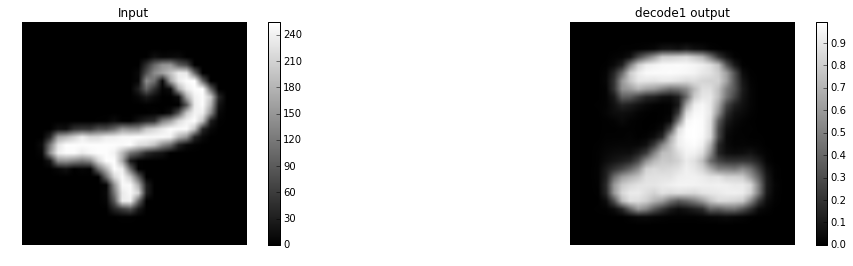

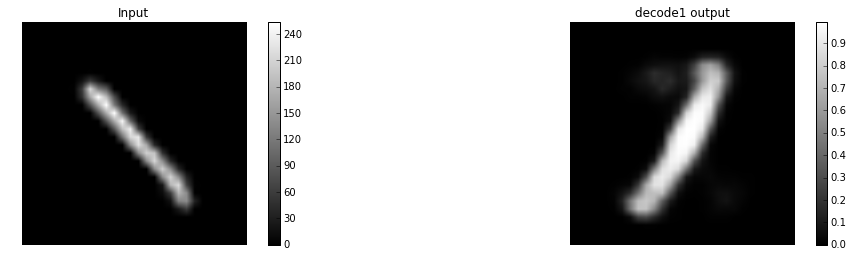

N50NUR


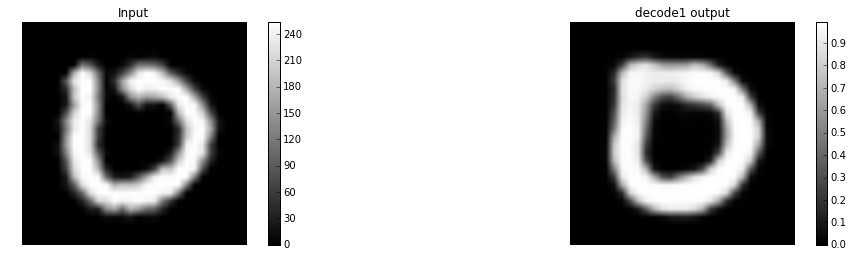

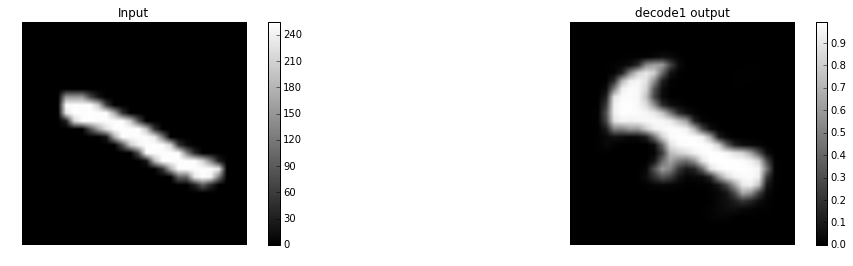

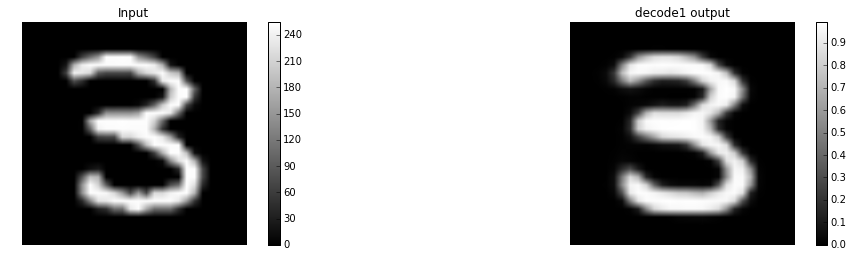

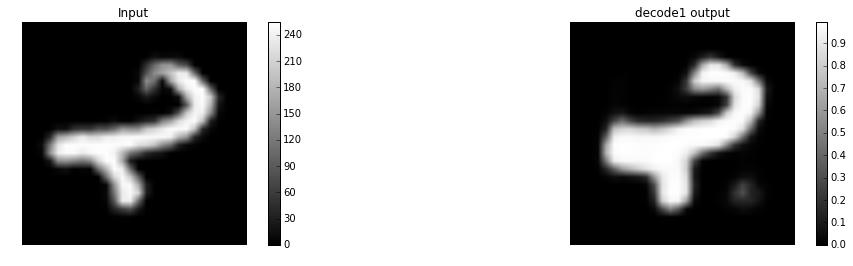

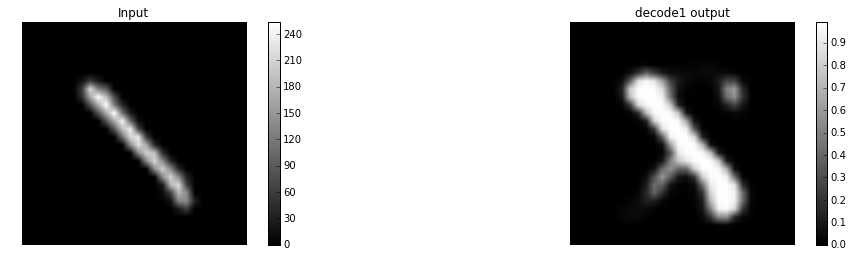

R


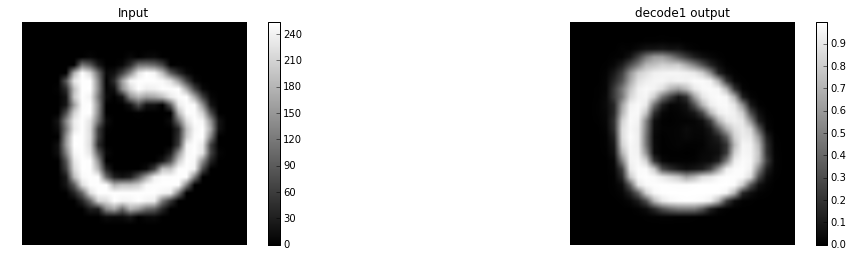

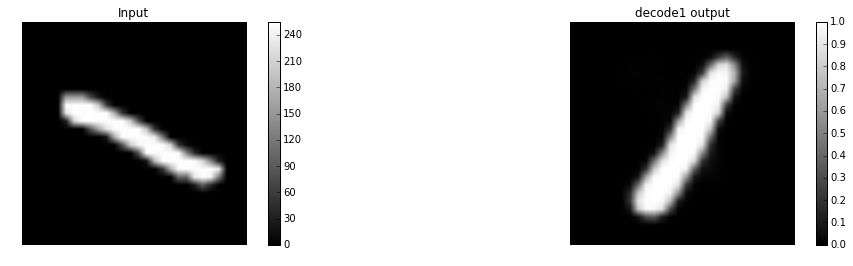

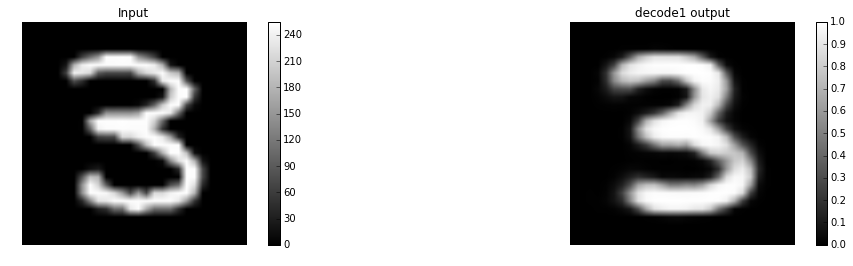

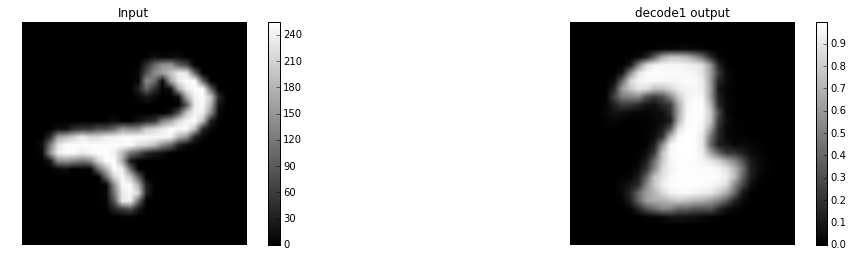

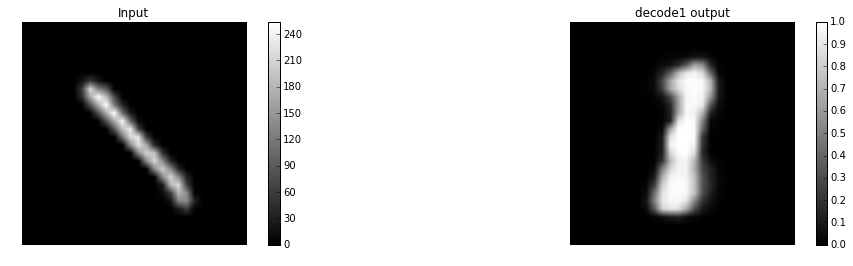

UR


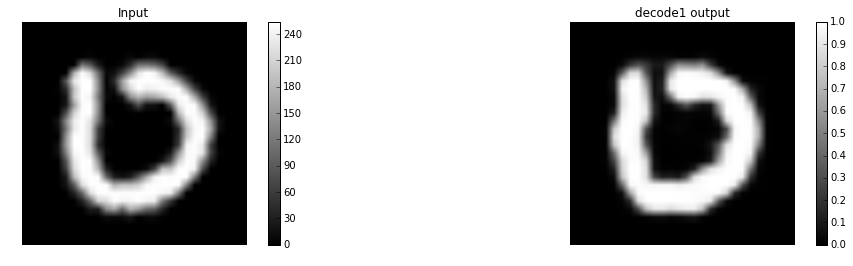

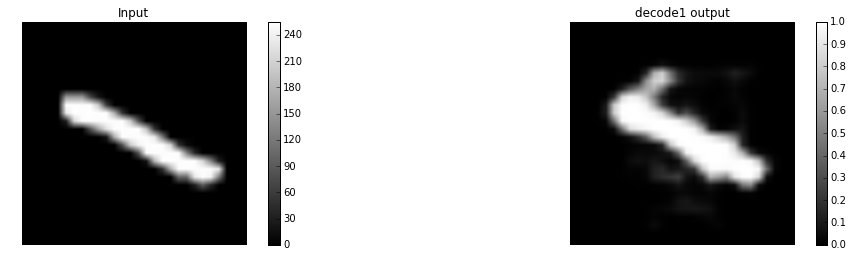

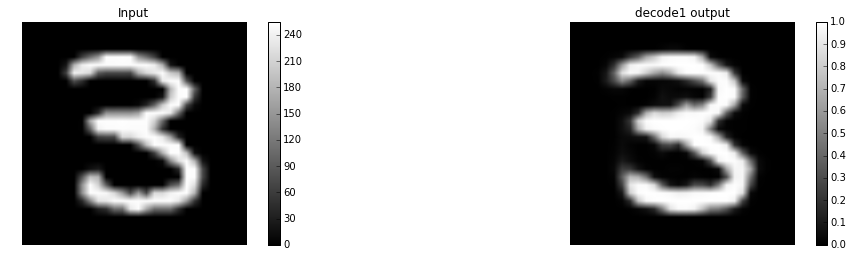

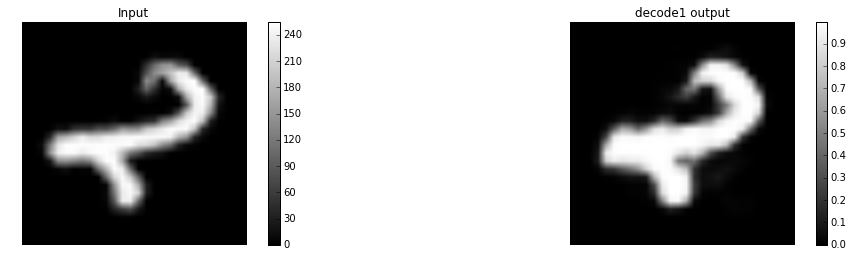

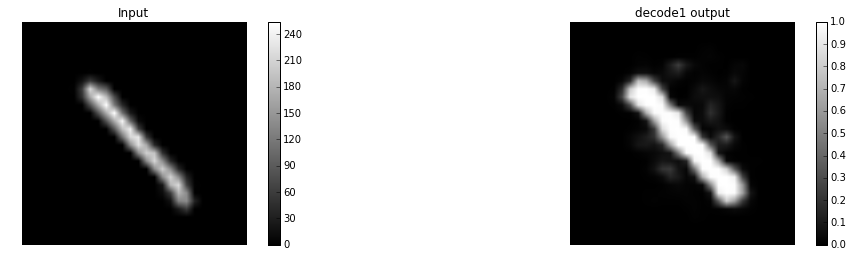

In [31]:
# Check weights

for k,v in sorted(models.items()):
    print(k)
    count = 0
    correct = 0
    matrix = defaultdict(int) # (real,pred) -> int
    labels_set = set()

    net = caffe.Net(deploy_proto, v, caffe.TEST)
    caffe.set_mode_cpu()
    lmdb_env = lmdb.open(test_lmdb)
    lmdb_txn = lmdb_env.begin()
    lmdb_cursor = lmdb_txn.cursor()
    for key, value in lmdb_cursor:
        datum = caffe.proto.caffe_pb2.Datum()
        datum.ParseFromString(value)
        label = int(datum.label)
        image = caffe.io.datum_to_array(datum)
        image = image.astype(np.uint8)

        out = net.forward_all(data=np.asarray([image]))
        #plabel = int(out['score'][0].argmax(axis=0))

        count = count + 1
        #if not iscorrect:
        #    print("\rError: key=%s, expected %i but predicted %i" \
        #            % (key, label, plabel))

        #sys.stdout.write("\rAccuracy: %.1f%%" % (100.*correct/count))
        #sys.stdout.flush()
        if count> 4:
            plt.figure(figsize=(18,4))
            plt.subplot(1,2,1)
            plt.imshow(image.reshape(28, 28).T, cmap='gray'); plt.axis('off')
            plt.colorbar()
            plt.title('Input')
            plt.subplot(1,2,2)
            plt.imshow(out['decode1neuron'].reshape(28, 28).T, cmap='gray'); 
            plt.axis('off')
            plt.title('decode1 output')
            plt.colorbar()
            plt.show()

        if count == 9:
            break
    #print(str(correct) + " out of " + str(count) + " were classified correctly")



AER
AEUR
AENR25
AENUR25
AENR50
AENUR50
AER
AEUR
AENR25
AENUR25
AENR50
AENUR50


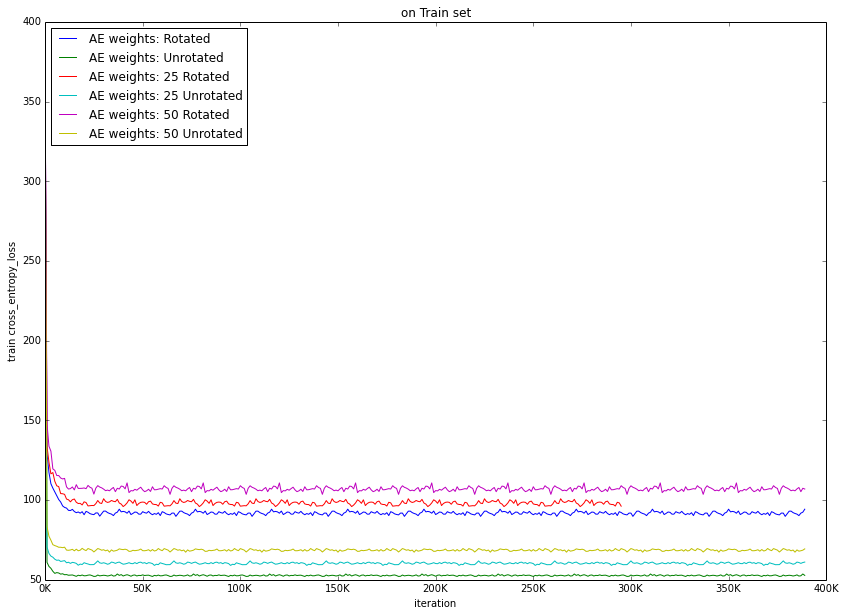

In [19]:
#Check learning
import sys
sys.path.append('/mnt/antares_raid/home/oliver/nideep')
sys.path.append('/mnt/antares_raid/home/oliver/Scripts/autoencoder')
from nideep.eval.learning_curve import LearningCurve
from nideep.eval.inference import infer_to_h5_fixed_dims, infer_to_lmdb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nideep.eval.learning_curve import LearningCurve
from nideep.eval.eval_utils import Phase
%matplotlib inline


exps = ['AER', 'AEUR', 'AENR25', 'AENUR25', 'AENR50', 'AENUR50']

#exps = ['AER', 'AEUR', 'RAND', 'AENR25', 'AENUR25', 'AENR50']
#exps = ['RAND', 'AENR25', 'AENUR25']

exp_labels = ['Rotated', 'Unrotated', '25 Rotated', '25 Unrotated', '50 Rotated' , '50 Unrotated']
date = '2408/'
exp_data = {'AER': {'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/R/log/log.log'},
        'AEUR': {'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/UR/log/log.log'},
        'AENR25':{'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/N25NR/log/log.log'},
        'AENUR25': {'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/N25NUR/log/log.log'},
        'AENR50':{'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/N50NR/log/log.log'},
        'AENUR50':{'log':'/mnt/antares_raid/home/oliver/Experiments/' + date + '/N50NUR/log/log.log'},
        }
for exp in exps:
    print(exp)
    e = LearningCurve(exp_data[exp]['log'])
    e.parse()
    for phase in [Phase.TRAIN, Phase.TEST]:
        exp_data[exp][phase] = {}
        exp_data[exp][phase]['num_iter'] = e.list('NumIters', phase)
        exp_data[exp][phase]['cross_entropy_loss'] = e.list('cross_entropy_loss', phase)
        exp_data[exp][phase]['l2_error'] = e.list('l2_error', phase)

plt.figure(figsize=(14,10))
xmax = 390000
ymin = 0.9
ymax = 0.96
for i, exp in enumerate(exps):
    print(exp)
    plt.subplot(1,1,1)
    phase = Phase.TRAIN
    plt.plot(exp_data[exp][phase]['num_iter'], exp_data[exp][phase]['cross_entropy_loss'], label='AE weights: %s' % (exp_labels[i],))
    plt.xlim(0,xmax)
    plt.xlabel('iteration')
    # format x-axis ticks
    ticks, _ = plt.xticks()
    plt.xticks(ticks, ["%dK" % int(t/1000) for t in ticks])
    plt.ylabel('train cross_entropy_loss')
    plt.title("on %s set" % (phase,))
    plt.legend(loc=2)
    


plt.show()